In [3]:
import numpy as np
import importlib, os, datetime, pickle
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython import display
from IPython.display import HTML, Image
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
from quick_sim import setup_sim


# import edward_tools.fq_runner as fq_runner
from edward_tools.cfqp_3D_potential import coupled_flux_qubit_3D_non_linear_approx_pot, coupled_flux_qubit_3D_non_linear_approx_force
from edward_tools.visualization import animate_sim_flux_qubit, plotFidelityBarChart, separate_by_state_2
from edward_tools.initial_state_sampling import extra_constraint_00_and_11_only
from NAND_PARAMETERS import *
import importlib

import kyle_tools as kt
import matplotlib.pyplot as plt

from edward_tools import cfq_3D_runner, coupled_fq_protocol_library

import edward_tools.cfq_batch_sweep as cfq_batch_sweep
import edward_tools.Analysis_tool.general_analysis_tools as general_analysis_tool
# from edward_tools.Analysis_tool.general_analysis_tools import show_phi_dc_with_time
import edward_tools.Analysis_tool.minimum_value_of_potential as minimum_value_of_potential
from edward_tools.couple_flux_qubit_metrics import fidelityEvaluation
from edward_tools import visualization

In [1153]:
def get_XYU(domain = [-4, 4], resolution = 50, detail_info = False, params = initial_parameter_dict, slice = [0, 0, 0]):
    """
    To get the 2D data of the potential for contour plots
    """
    x_vec = np.linspace(domain[0], domain[1], resolution)
    phi_1xdc, phi_2xdc, phi_3xdc = params['phi_1xdc'], params['phi_2xdc'], params['phi_3xdc']
    X, Y = np.meshgrid(x_vec, x_vec)
    U_12 = coupled_fq_pot.potential(X, Y, slice[2], phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_23 = coupled_fq_pot.potential(slice[0], X, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_13 = coupled_fq_pot.potential(X, slice[1], Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    return X, Y, U_12, U_23, U_13
    
def get_XYU_6_plane(domain = [-4, 4], resolution = 50, detail_info = False, params = initial_parameter_dict):
    """
    To get the 2D data of the potential for contour plots
    """
    x_vec = np.linspace(domain[0], domain[1], resolution)
    X, Y = np.meshgrid(x_vec, x_vec)
    phi_1xdc, phi_2xdc, phi_3xdc = params['phi_1xdc'], params['phi_2xdc'], params['phi_3xdc']
    x, y = np.meshgrid(x_vec, x_vec)
    U_12_top = coupled_fq_pot.potential(X, Y, 2.043, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_12_bottom = coupled_fq_pot.potential(X, Y, -2.043, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_23_right = coupled_fq_pot.potential(2.043, X, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_23_left = coupled_fq_pot.potential(-2.043, X, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_13_front = coupled_fq_pot.potential(X, 2.043, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_13_back = coupled_fq_pot.potential(X, -2.043, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    return X, Y, U_12_top, U_12_bottom, U_23_left, U_23_right, U_13_front, U_13_back

In [5]:
{
    0: "U0_1", 1: "U0_2", 2: "U0_3", 3: "gamma_1", 4: "gamma_2", 5: "gamma_3", 6: "beta_1", 7: "beta_2",
    8: "beta_3", 9: "d_beta_1", 10: "d_beta_2", 11: "d_beta_3", 12: "phi_1x", 13: "phi_2x",
    14: "phi_3x", 15: "phi_1xdc", 16: "phi_2xdc", 17: "phi_3xdc", 18: "mu_12", 19: "mu_13", 20: "mu_23"
}

default_potential_params = [1, 1, 1, 20, 20, 20, 2.3, 2.3, 2.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
len(default_potential_params)

21

In [2769]:
has_velocity = True

PHI_0 = 2.067833848 * 1e-15
k_B = 1.38e-23
T = 0.5
k_BT = k_B * T

C_factor = 1
L_factor = 1
R_factor = 100
I_m_factor = 0

I_p_1, I_p_2, I_p_3 = 4e-6, 4e-6 , 4e-6  # Amp
I_m_1, I_m_2, I_m_3 = 7e-9 * I_m_factor, 7e-9 * I_m_factor, 7e-9 * I_m_factor              # Amp
R_1, R_2, R_3 = 1 * R_factor, 1 * R_factor, 1 * R_factor           # ohm
C_1, C_2, C_3 = 500e-15 * C_factor, 500e-15 * C_factor, 500e-15 * C_factor                 # F
L_1, L_2, L_3 = 140e-12 * L_factor, 140e-12 * L_factor, 140e-12 * L_factor                 # H  

freq = 1/np.sqrt(C_1 * L_1)
characteristic_time = np.sqrt(C_1 * C_factor * L_1 * L_factor)

In [2770]:
m_c = C_1
m_1, m_2, m_3 = C_1, C_2, C_3
x_c = PHI_0 / (2 * np.pi)
t_c = np.sqrt(L_1 * C_1)
v_c = x_c / t_c


U0_1 = m_c * x_c**2 / t_c**2 / k_BT
U0_2 = m_2 * x_c**2 / t_c**2 / k_BT
kappa_1, kappa_2, kappa_3, kappa_4 = 1/U0_1, 1/U0_1, 1/U0_1, 1/U0_1

# phi
lambda_1 = 2 * np.sqrt(L_1 * C_1) / (C_1 * R_1)
theta_1  = 1
eta_1    = np.sqrt(np.sqrt(L_1 * C_1)/ (R_1 * C_1)) * np.sqrt(2 * kappa_1 / 1**2)

lambda_2 = 2 * np.sqrt(L_1 * C_1) / (C_2 * R_2)
theta_2  = 1 / (C_2/C_1)
eta_2    = np.sqrt(np.sqrt(L_1 * C_1)/ (R_1 * C_1)) * np.sqrt(2 * kappa_2 * (R_1 * C_1**2) / (R_2 * C_2**2))

lambda_3 = 2 * np.sqrt(L_1 * C_1) / (C_3 * R_3)
theta_3  = 1 / (C_3/C_1)
eta_3    = np.sqrt(np.sqrt(L_1 * C_1)/ (R_1 * C_1)) * np.sqrt(2 * kappa_2 * (R_1 * C_1**2) / (R_3 * C_3**2))

# phi_dc

lambda_4 = 2 * np.sqrt(L_1 * C_1) / (C_1 * R_1)
theta_4  = 4
eta_4    = np.sqrt(np.sqrt(L_1 * C_1)/ (R_1 * C_1)) * np.sqrt(8 * kappa_3)

lambda_5 = 2 * np.sqrt(L_1 * C_1) / (C_2 * R_2)
theta_5  = 4 / (C_2/C_1)
eta_5    = np.sqrt(np.sqrt(L_1 * C_1)/ (R_1 * C_1)) * np.sqrt(8 * kappa_4 * (R_1 * C_1**2) / (R_2 * C_2**2))

lambda_6 = 2 * np.sqrt(L_1 * C_1) / (C_3 * R_3)
theta_6  = 4 / (C_3/C_1)
eta_6    = np.sqrt(np.sqrt(L_1 * C_1)/ (R_1 * C_1)) * np.sqrt(8 * kappa_4 * (R_1 * C_1**2) / (R_3 * C_3**2))

gamma_1, gamma_2, gamma_3 = 20, 20, 20


beta_1 = 2 * np.pi * L_1 * I_p_1 / PHI_0; 
beta_2 = 2 * np.pi * L_2 * I_p_2 / PHI_0;
beta_3 = 2 * np.pi * L_3 * I_p_3 / PHI_0;

beta_1 = 2.3
beta_2 = 2.3
beta_3 = 2.3

d_beta_1 = 2 * np.pi * L_1 * I_m_1 / PHI_0; 
d_beta_2 = 2 * np.pi * L_2 * I_m_2 / PHI_0;
d_beta_3 = 2 * np.pi * L_3 * I_m_3 / PHI_0;

_lambda = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6])
_theta  = np.array([theta_1, theta_2, theta_3, theta_4, theta_5, theta_6])
_eta  =   np.array([eta_1, eta_2, eta_3, eta_4, eta_5, eta_6])

v_1 = np.random.normal(0, np.sqrt(k_BT/m_1)) / v_c
v_2 = np.random.normal(0, np.sqrt(k_BT/m_2)) / v_c
v_3 = np.random.normal(0, np.sqrt(k_BT/m_3)) / v_c
v_4 = np.random.normal(0, np.sqrt(k_BT/(m_1/4))) / v_c
v_5 = np.random.normal(0, np.sqrt(k_BT/(m_2/4))) / v_c
v_6 = np.random.normal(0, np.sqrt(k_BT/(m_3/4))) / v_c

In [2771]:
print(f"L_1 = {L_1 * 1e12:.3g}pH, T = {T}K")
print(f"freq = {freq / 1e9:.3g}GHz")
print(characteristic_time)
print(1/U0_1)

L_1 = 140pH, T = 0.5K
freq = 120GHz
8.366600265340756e-12
0.008918782710086262


In [2772]:
experiment_comment = "Testing"

In [2773]:
"""
# step 0: modify parameters
- All the parameters are stored in a separate file PARAMETER_INPUT
- You can override some of the parameters here.
"""
params = {}
params['N'] = 500
params['dt'] = 1/100
params['lambda'] = 1
params['beta'] = 1
params['sim_params'] = [_lambda, _theta, _eta]
params['target_work'] = None
params['applyOffset'] = False
params['measureWorkWithOffset'] = False
params['monitor_work_dist_in_whole_process'] = True # To monitor the work process
params['comment'] = experiment_comment
params['capacitance'] = np.array([C_1, C_2, C_3, C_1/4, C_2/4, C_3/4])
params['mass'] = np.array([1, 1, 1, 1/4, 1/4, 1/4])
params['v_c'] = x_c/t_c
params['k_BT'] = k_BT
params['U0'] = U0_1
params['as_step'] = np.s_[::10] # the time step to skep for the all_state
params['percentage'] = 1 # For what percentage of the total sample do you want to keep in the output all_state


In [2774]:
"""
# step 2: Define initial condition and protocol
"""
manual_domain=[np.array([-4, -4, -4]), np.array([4, 4, 4])]



# µ = 0.06, φ2xdc = 1.79, φ1x = 0.59, and φ2x = 0.10.
    
initial_parameter_dict = {
    "U0_1": U0_1, "U0_2": U0_2, "U0_3": U0_2, "gamma_1": gamma_1, "gamma_2": gamma_2, "gamma_3": gamma_3, 
    "beta_1": beta_1, "beta_2": beta_2, "beta_3": beta_3, "d_beta_1": d_beta_1, "d_beta_2": d_beta_2, "d_beta_3": d_beta_3, "phi_1x": 0, "phi_2x": 0, "phi_3x": 0, "phi_1xdc": 0, "phi_2xdc": 0, "phi_3xdc": 0, "mu_12":0, "mu_13": 0, "mu_23": 0
}


In [2775]:
"""
# step 1: Define potential
"""
coupled_fq_default_param = [1, 1, 1, 20, 20, 20, 2.3, 2.3, 2.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[phi_1_bound, phi_2_bound, phi_3_bound, phi_1dc_bound, phi_2dc_bound, phi_3dc_bound] = np.array([4, 4, 4, 4, 4, 4])
contour_range = [300, 2000]
    
coupled_fq_domain = [[-phi_1_bound, -phi_2_bound, -phi_3_bound, -phi_1dc_bound, -phi_2dc_bound, -phi_3dc_bound], \
                     [phi_1_bound, phi_2_bound, phi_3_bound, phi_1dc_bound, phi_2dc_bound, phi_3dc_bound]]

# coupled_fq_pot = Potential(coupled_flux_qubit_pot_with_offset_at_00_xy, coupled_flux_qubit_force, 14, 4,\
#                            default_params = coupled_fq_default_param,  relevant_domain = coupled_fq_domain)

coupled_fq_pot = Potential(coupled_flux_qubit_3D_non_linear_approx_pot, coupled_flux_qubit_3D_non_linear_approx_force, 21, 6,\
                           default_params = initial_parameter_dict,  relevant_domain = coupled_fq_domain)


In [2776]:
len(coupled_fq_default_param)

21

# protocol settings

In [2777]:
zeroDissipation = False
saveAllStates = True

params['sim_params'] = [_lambda, _theta, _eta]

if zeroDissipation:
    params['sim_params'] = [_lambda * 0, _theta, _eta * 0]

params['circuit_parameters'] = {
    "C_factor":C_factor, "L_factor": L_factor, "R_factor": R_factor, "I_m_factor": I_m_factor, "T": T, 
    "I_p_1": I_p_1, "I_p_2": I_p_2, "I_p_3": I_p_3, "I_m_1": I_m_1, "I_m_2": I_m_2, "I_m_3": I_m_3,
    "R_1": R_1, "R_2": R_2, "R_3": R_3, "C_1": C_1, "C_2": C_2, "C_3": C_3, "L_1": L_1, "L_2": L_2, "L_3": L_3, 
    "characteristic_time": np.sqrt(C_1 * C_factor * L_1 * L_factor), "gamma": gamma_1
}


# bookmark
initial_parameter_dict["phi_1xdc"] = 0
initial_parameter_dict["phi_2xdc"] = 0
initial_parameter_dict["phi_3xdc"] = 0
initial_parameter_dict["phi_1x"]   = 0
initial_parameter_dict["phi_2x"]   = 0
initial_parameter_dict["phi_3x"]   = 0
initial_parameter_dict["mu_12"]      = 0
initial_parameter_dict["mu_13"]      = 0
initial_parameter_dict["mu_23"]      = 0

In [2778]:
# protocol_list = [{
#     'duration': 100,
#     'phi_1x': 0.0,
#     'phi_2x': 0.0,
#     'phi_3x': 0.0,
#     'mu_12': 0.0,
#     'mu_13': 0.0,
#     'mu_23': 0.0,
#     'phi_1xdc': 0,
#     'phi_2xdc': 0,
#     'phi_3xdc': np.pi,
#     'name': 'conditional_tilt_xz'
# }] * 2 + [{
#     'duration': 100,
#     'phi_1x': 0.0,
#     'phi_2x': 0.0,
#     'phi_3x': 0.0,
#     'mu_12': 0.0,
#     'mu_13': 0.0,
#     'mu_23': 0.60,
#     'phi_1xdc': 0,
#     'phi_2xdc': np.pi,
#     'phi_3xdc': 0,
#     'name': 'conditional_tilt_xz'
# }] * 2 + [{
#     'duration': 100,
#     'phi_1x': 0.0,
#     'phi_2x': 0.0,
#     'phi_3x': 0.0,
#     'mu_12': 0.0,
#     'mu_13': 0.0,
#     'mu_23': 0.0,
#     'phi_1xdc': 0,
#     'phi_2xdc': 0,
#     'phi_3xdc': 0,
#     'name': 'conditional_tilt_xz'
# }] * 2


In [2779]:
protocol_list = []
# protocol_list =  [{
#     'duration': 100,
#     'phi_1x': 0.0,
#     'phi_2x': 0.0,
#     'phi_3x': 0.0,
#     'mu_12': 0.15,
#     'mu_13': 0.25,
#     'mu_23': 0.15,
#     'phi_1xdc': 0.0,
#     'phi_2xdc': 0,
#     'phi_3xdc': 0,
#     'name': 'conditional_tilt_xz'
# }] * 2 

# # protocol_list =+ [{
# #     'duration': 100,
# #     'phi_1x': -0.1,
# #     'phi_2x': -0.1,
# #     'phi_3x': -0.1,
# #     'mu_12': 0.0,
# #     'mu_13': 0.15,
# #     'mu_23': 0.15,
# #     'phi_1xdc': 0.0,
# #     'phi_2xdc': 0,
# #     'phi_3xdc': np.pi/3,
# #     'name': 'conditional_tilt_xz'
# # }] * 2 
protocol_list = []
protocol_list += [{
    'duration': 100,
    'phi_1x': 0.0,
    'phi_2x': 0.0,
    'phi_3x': 0,
    'mu_12': 0,
    'mu_13': 0.,
    'mu_23': 0.0,
    'phi_1xdc': 0,
    'phi_2xdc': 0,
    'phi_3xdc': 0,
    'name': 'conditional_tilt_xz'
}] * 2

# protocal

In [2780]:

action_1 = {
    'duration': 0.02,
    'phi_1x': 0.1,
    'phi_2x': 0.,
    'phi_3x': 0,
    'mu_12': -0.05,
    'mu_13': -0.05,
    'mu_23': -0.05,
    'phi_1xdc': np.pi * 0.6,
    'phi_2xdc': 0,
    'phi_3xdc': 0,
    'name': 'conditional_tilt_xz'
}

In [2828]:
protocol_list = []
action_1 = {
    'duration': 0.02,
    'phi_1x': 0.09,
    'phi_2x': 0.,
    'phi_3x': 0,
    'mu_12': -0.02,
    'mu_13': -0.02,
    'mu_23': -0.02,
    'phi_1xdc': np.pi * 0.62,
    'phi_2xdc': 0,
    'phi_3xdc': 0,
    'name': 'conditional_tilt_xz'
}

protocol_list.append(action_1.copy())
protocol_list[-1]['duration'] = 300

In [2829]:
# protocol_list = []

action_2 = {
    'duration': 100,
    'phi_1x': 0,
    'phi_2x': 0.0,
    'phi_3x': 0.0,
    'mu_12': 0.,
    'mu_13': 0.,
    'mu_23': 0.,
    'phi_1xdc': 0,
    'phi_2xdc': 0,
    'phi_3xdc': 0.0,
    'name': 'conditional_tilt_xz'
}
protocol_list.append(action_2.copy())
protocol_list[-1]['duration'] = 200
# protocol_list.append(action_2.copy())
# protocol_list[-1]['duration'] = 50
# protocol_list.append(action_1.copy())
# protocol_list[-1]['duration'] = 20

# first initialization

### create initial state 

In [2830]:
importlib.reload(coupled_fq_protocol_library)
default_init_state = True
default_init_state_array = {
    0: "test_state.npy",
    1: "default_init_state_1 (3D, 0.5K).npy",
    2: "beta_1.7_T_0.5K_init_state.npy",
    3: "beta_3.5_T_0.5K_init_state.npy"
}
init_state_choice = 1

if default_init_state:
    init_state = np.load(default_init_state_array[init_state_choice])
    
else:
    init_state = None

In [2831]:
computation_protocol_parameter_dict = coupled_fq_protocol_library.customizedProtocol(initial_parameter_dict, protocol_list, initial_parameter_dict.keys())

# storage_protocol, comp_protocol = create_system(computation_protocol_parameter_dict, modifiedFunction = None)

In [2832]:
importlib.reload(coupled_fq_protocol_library)

storage_protocol, comp_protocol = coupled_fq_protocol_library.create_system(computation_protocol_parameter_dict, initial_parameter_dict.keys(), modifiedFunction = None)

cfqr = cfq_3D_runner.coupledFluxQubitRunner(potential = coupled_fq_pot, params = params, \
                                                storage_protocol= storage_protocol, \
                                                computation_protocol= comp_protocol, \
                                         protocol_list = protocol_list, \
                                        has_velocity=has_velocity, measure_all_states = True)
cfqr.initialize_sim()
cfqr.set_sim_attributes(init_state = init_state)
print("-" * 5)
print(f"The mean KE of all particle = {np.mean(cfqr.system.get_kinetic_energy(init_state)):.3g}")

use old initial_state
as step value: slice(None, None, 10), sampleSize: 500
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py, sim_params:  [array([0.33466401, 0.33466401, 0.33466401, 0.33466401, 0.33466401,
       0.33466401]), array([1., 1., 1., 4., 4., 4.]), array([0.05463328, 0.05463328, 0.05463328, 0.10926657, 0.10926657,
       0.10926657])]
from quick_sim.py
gamma: [0.33466401 0.33466401 0.33466401 0.33466401 0.33466401 0.33466401], theta: [1. 1. 1. 4. 4. 4.] and eta: [0.05463328 0.05463328 0.05463328 0.10926657 0.10926657 0.10926657]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 500.0
from simulation.py: number of steps: 50000, dt: 0.01
-----
The mean KE of all particle = 2.98


In [2833]:
cfqr.run_sim(init_state = init_state)


 initializing...
use old initial_state
as step value: slice(None, None, 10), sampleSize: 500
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py, sim_params:  [array([0.33466401, 0.33466401, 0.33466401, 0.33466401, 0.33466401,
       0.33466401]), array([1., 1., 1., 4., 4., 4.]), array([0.05463328, 0.05463328, 0.05463328, 0.10926657, 0.10926657,
       0.10926657])]
from quick_sim.py
gamma: [0.33466401 0.33466401 0.33466401 0.33466401 0.33466401 0.33466401], theta: [1. 1. 1. 4. 4. 4.] and eta: [0.05463328 0.05463328 0.05463328 0.10926657 0.10926657 0.10926657]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 500.0
from simulation.py: number of steps: 50000, dt: 0.01

 running sim...
work_doneg step 49999
final_state
all_state

 analyzing output...


In [2843]:
particle_index = cfqr.separate_by_state(cfqr.init_state)
index_array = particle_index.values()
particle_color = ["#E69F00",  "#56B4E9",  "#009E73",  "#F5C710",  "#0072B2",  "#D55E00",  "#CC79A7", "#999999",  "#000000"]
all_states = cfqr.sim.output.all_state["states"]

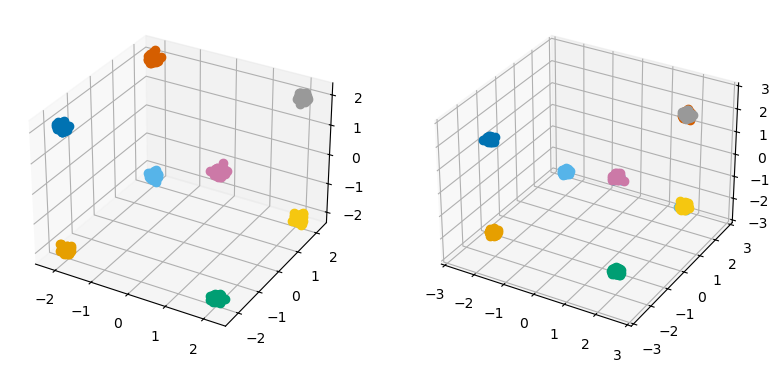

In [2844]:
init_state = cfqr.init_state
final_state = cfqr.sim.output.final_state

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

for key, index, color in zip(particle_index.keys(), particle_index.values(), particle_color):
    xs = init_state[index][:, 0, 0]
    ys = init_state[index][:, 1, 0]
    zs = init_state[index][:, 2, 0]
    graph = ax.plot(xs, ys, zs, c = color, label = key, linestyle="", marker="o")

ax = fig.add_subplot(1, 2, 2, projection='3d')

for key, index, color in zip(particle_index.keys(), particle_index.values(), particle_color):
    xs = final_state[index][:, 0, 0]
    ys = final_state[index][:, 1, 0]
    zs = final_state[index][:, 2, 0]
    graph = ax.plot(xs, ys, zs, c = color, label = key, linestyle="", marker="o")

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

plt.show()

In [2845]:
average_point = []
for key, index, color in zip(particle_index.keys(), particle_index.values(), particle_color):
    average_point.append([np.mean(final_state[index][:, 0, 0]), np.mean(final_state[index][:, 1, 0]), np.mean(final_state[index][:, 2, 0])])

# project to different plane

## project to xy plane

In [2846]:
final_params_key = computation_protocol_parameter_dict.keys()
final_params_value = [item[-1] for item in computation_protocol_parameter_dict.values()]
final_params = dict(zip(final_params_key, final_params_value))
del final_params['t']

In [2847]:
top_xy = [0, 1, 2, 3]
top_xy_z_coord_array = []
bottom_xy = [4, 5, 6, 7]
bottom_xy_z_coord_array = []

for i, key in enumerate(particle_index.keys()):
    if i in top_xy:
        mean_z = np.mean(final_state[particle_index[key]][:, 2, 0])
        # print(mean_y)
        top_xy_z_coord_array.append(mean_y)
# print(f"mean value of front_xz = {np.mean(front_xz_y_coord_array):.3g}, std = {np.std(front_xz_y_coord_array):.3g}")
print("-" * 20)
for i, key in enumerate(particle_index.keys()):
    if i in back_xz:
        mean_z = np.mean(final_state[particle_index[key]][:, 2, 0])
        # print(mean_y)
        bottom_xy_z_coord_array.append(mean_y)
# print(f"mean value of back_xz = {np.mean(back_xz_y_coord_array):.3g}, std = {np.std(back_xz_y_coord_array):.3g}")


--------------------


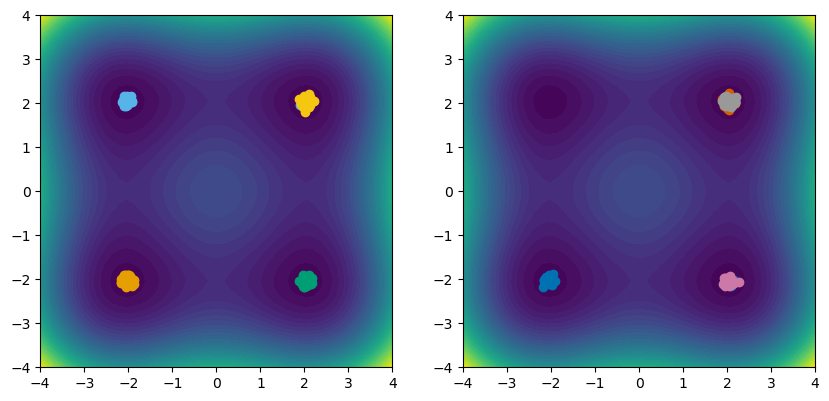

In [2848]:
# xy plane: top [4, 5, 6, 7], back [0, 1, 2, 3]

fig, ax = plt.subplots(1, 2, figsize = [10, 5])

X, Y, U_12, U_23, U_13 = get_XYU(params = final_params, slice = [0, np.mean(top_xy_z_coord_array), 0])
ax[0].contourf(X, Y, U_12, 40)
ax[0].set_aspect(1)

X, Y, U_12, U_23, U_13 = get_XYU(params = final_params, slice = [0, np.mean(bottom_xy_z_coord_array), 0])
ax[1].contourf(X, Y, U_12, 40)
ax[1].set_aspect(1)

for i, key in enumerate(particle_index.keys()):
    if i in top_xy:
        x, z = final_state[particle_index[key]][:, 0, 0], final_state[particle_index[key]][:, 1, 0]
        ax[0].scatter(x, z, color = particle_color[i])

for i, key in enumerate(particle_index.keys()):
    if i in bottom_xy:
        x, z = final_state[particle_index[key]][:, 0, 0], final_state[particle_index[key]][:, 1, 0]
        ax[1].scatter(x, z, color = particle_color[i])

The work done for 000 = 1.18
The work done for 001 = 5.93
The work done for 010 = 0.924
The work done for 011 = 0.823
The work done for 100 = 5.73
The work done for 101 = 44.5
The work done for 110 = 1.03
The work done for 111 = 0.752


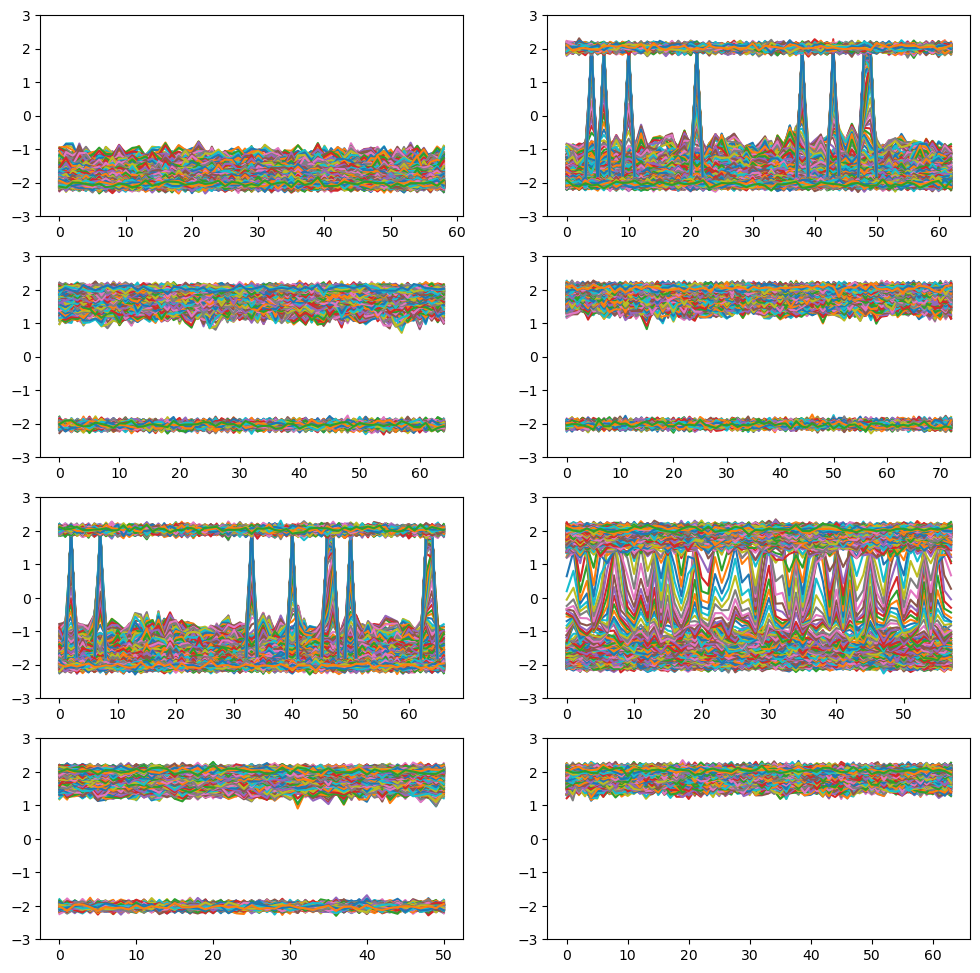

In [2860]:
fig, ax = plt.subplots(4, 2, figsize = [12, 12])
ax_flatten = ax.flatten()
for i, key in enumerate(particle_index.keys()):
    print(f"The work done for {key} = {np.mean(cfqr.sim.work_dist_array[particle_index[key], ...]):.3g}")
    ax_flatten[i].plot(all_states[particle_index[key],::10, 0, 0], label = "x")
    ax_flatten[i].plot(all_states[particle_index[key],::10, 1, 0], label = "y")
    ax_flatten[i].plot(all_states[particle_index[key],::10, 2, 0], label = "z")
    # ax_flatten[i].plot(cfqr.system.get_kinetic_energy(all_states[particle_index[key],...]), color = particle_color[i], label = key)
    ax_flatten[i].set_ylim(-3, 3)
    # ax_flatten[i].legend()

## project to xz plane

In [2849]:
# xz plane: front [0, 2, 4, 6], back [1, 3, 5, 7]
front_xz = [0, 2, 4, 6]
front_xz_y_coord_array = []
back_xz = [1, 3, 5, 7]
back_xz_y_coord_array = []

for i, key in enumerate(particle_index.keys()):
    if i in front_xz:
        mean_y = np.mean(final_state[particle_index[key]][:, 1, 0])
        # print(mean_y)
        front_xz_y_coord_array.append(mean_y)
# print(f"mean value of front_xz = {np.mean(front_xz_y_coord_array):.3g}, std = {np.std(front_xz_y_coord_array):.3g}")
# print("-" * 20)
for i, key in enumerate(particle_index.keys()):
    if i in back_xz:
        mean_y = np.mean(final_state[particle_index[key]][:, 1, 0])
        # print(mean_y)
        back_xz_y_coord_array.append(mean_y)
# print(f"mean value of back_xz = {np.mean(back_xz_y_coord_array):.3g}, std = {np.std(back_xz_y_coord_array):.3g}")


fig, ax = plt.subplots(1, 2, figsize = [10, 5])

X, Y, U_12, U_23, U_13 = get_XYU(params = final_params, slice = [0, np.mean(front_xz_y_coord_array), 0])
ax[0].contourf(X, Y, U_13, 40)
ax[0].set_aspect(1)

X, Y, U_12, U_23, U_13 = get_XYU(params = final_params, slice = [0, np.mean(back_xz_y_coord_array), 0])
ax[1].contourf(X, Y, U_13, 40)
ax[1].set_aspect(1)

for i, key in enumerate(particle_index.keys()):
    if i in front_xz:
        x, z = final_state[particle_index[key]][:, 0, 0], final_state[particle_index[key]][:, 2, 0]
        ax[0].scatter(x, z, color = particle_color[i])

for i, key in enumerate(particle_index.keys()):
    if i in back_xz:
        x, z = final_state[particle_index[key]][:, 0, 0], final_state[particle_index[key]][:, 2, 0]
        ax[1].scatter(x, z, color = particle_color[i])
plt.close()

In [2850]:
print(f"W = {np.mean(cfqr.sim.work_dist_array):.3g}")

W = 7.26


The work done for 000 = 1.18
The work done for 001 = 5.93
The work done for 010 = 0.924
The work done for 011 = 0.823
The work done for 100 = 5.73
The work done for 101 = 44.5
The work done for 110 = 1.03
The work done for 111 = 0.752


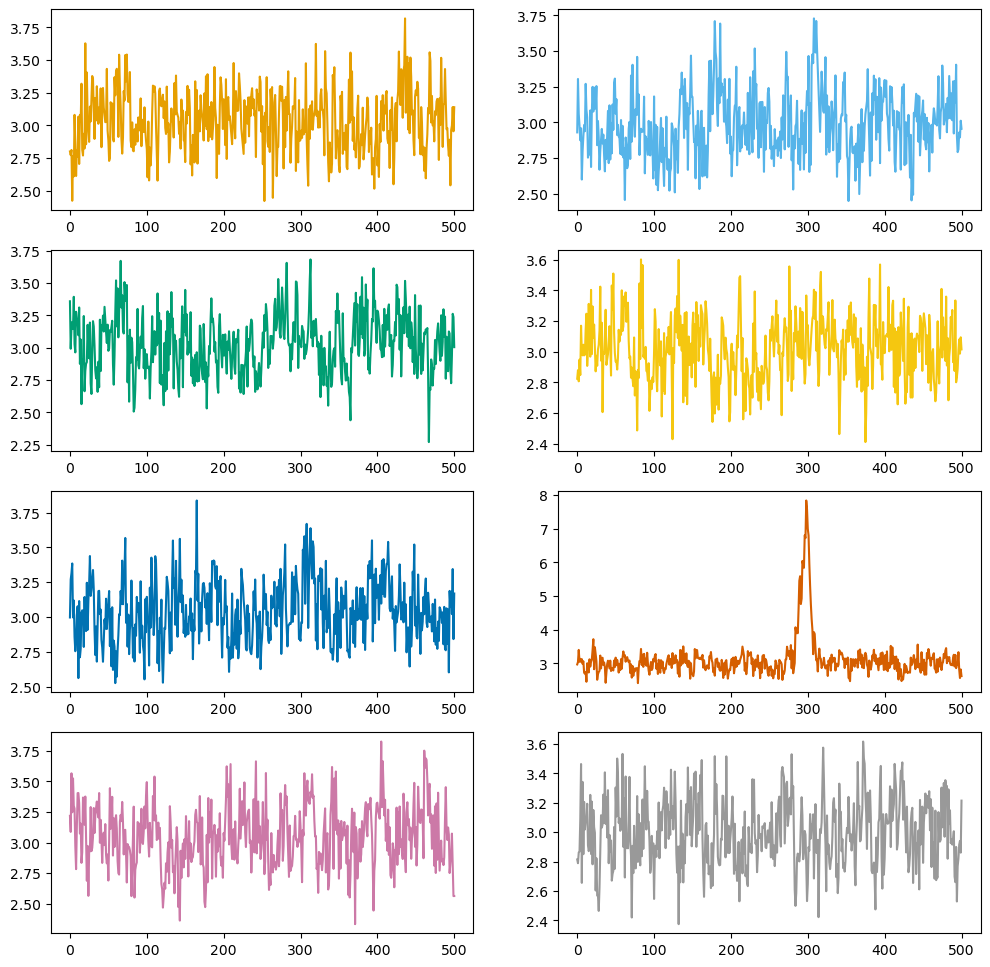

In [2851]:
fig, ax = plt.subplots(4, 2, figsize = [12, 12])
ax_flatten = ax.flatten()
for i, key in enumerate(particle_index.keys()):
    print(f"The work done for {key} = {np.mean(cfqr.sim.work_dist_array[particle_index[key], ...]):.3g}")
    ax_flatten[i].plot(np.mean(cfqr.system.get_kinetic_energy(all_states[particle_index[key],::10, ...]), axis = 0), color = particle_color[i], label = key)
    # ax_flatten[i].plot(cfqr.system.get_kinetic_energy(all_states[particle_index[key],...]), color = particle_color[i], label = key)
    # ax_flatten[i].legend()

# plot in 3D box

In [2520]:
particle_index.keys()

dict_keys(['000', '001', '010', '011', '100', '101', '110', '111'])

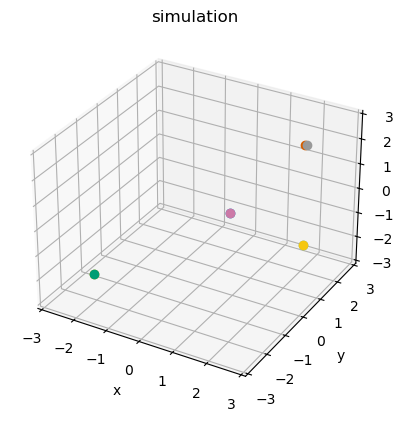

In [2521]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("simulation")
for key, point, color in zip(particle_index.keys(), average_point, particle_color):
    graph = ax.plot(point[0], point[1], point[2], c = color, label = key, linestyle="", marker="o")


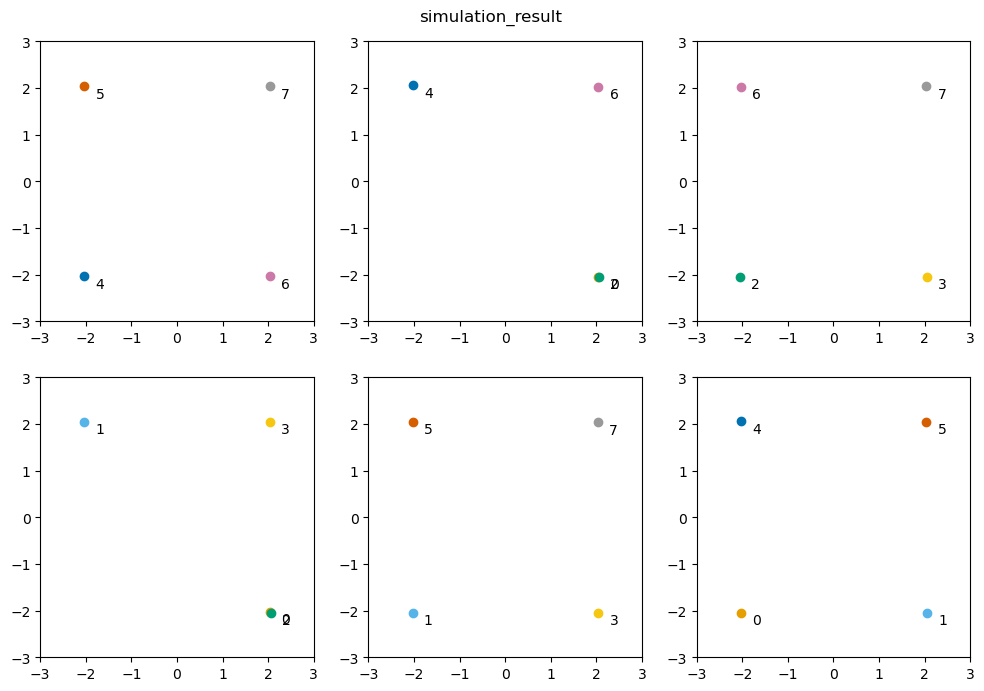

In [1900]:
fig, ax = plt.subplots(2, 3, figsize=[12, 8])
ax_flatten = ax.flatten()

fig.suptitle("simulation_result", y = 0.92)
xy_top_plane = [4, 5, 6, 7]
xy_bottom_plane = [0, 1, 2, 3]
xz_front_plane = [0, 2, 4, 6]
xz_back_plane = [1, 3, 5, 7]
yz_right_plane = [2, 3, 6, 7]
yz_left_plane = [0, 1, 4, 5]

for x in xy_top_plane:
    ax_flatten[0].plot(average_point[x][0], average_point[x][1], c = particle_color[x],marker="o")
    ax_flatten[0].text(average_point[x][0] + 0.25, average_point[x][1] - 0.25, x)
    ax_flatten[0].set_xlim(-3, 3)
    ax_flatten[0].set_ylim(-3, 3)

for x in xy_bottom_plane:
    ax_flatten[3].plot(average_point[x][0], average_point[x][1], c = particle_color[x],marker="o")
    ax_flatten[3].text(average_point[x][0] + 0.25, average_point[x][1] - 0.25, x)
    ax_flatten[3].set_xlim(-3, 3)
    ax_flatten[3].set_ylim(-3, 3)

for x in xz_front_plane:
    ax_flatten[1].plot(average_point[x][0], average_point[x][2], c = particle_color[x],marker="o")
    ax_flatten[1].text(average_point[x][0] + 0.25, average_point[x][2] - 0.25, x)
    ax_flatten[1].set_xlim(-3, 3)
    ax_flatten[1].set_ylim(-3, 3)

for x in xz_back_plane:
    ax_flatten[4].plot(average_point[x][0], average_point[x][2], c = particle_color[x],marker="o")
    ax_flatten[4].text(average_point[x][0] + 0.25, average_point[x][2] - 0.25, x)
    ax_flatten[4].set_xlim(-3, 3)
    ax_flatten[4].set_ylim(-3, 3)

for x in yz_right_plane:
    ax_flatten[2].plot(average_point[x][1], average_point[x][2], c = particle_color[x],marker="o")
    ax_flatten[2].text(average_point[x][1] + 0.25, average_point[x][2] - 0.25, x)
    ax_flatten[2].set_xlim(-3, 3)
    ax_flatten[2].set_ylim(-3, 3)

for x in yz_left_plane:
    ax_flatten[5].plot(average_point[x][1], average_point[x][2], c = particle_color[x],marker="o")
    ax_flatten[5].text(average_point[x][1] + 0.25, average_point[x][2] - 0.25, x)
    ax_flatten[5].set_xlim(-3, 3)
    ax_flatten[5].set_ylim(-3, 3)



In [1901]:
average_point

[[2.041413894571156, -2.0306292244530266, -2.0476030663807516],
 [-2.0334559625231257, 2.0429340543243653, -2.047911318683445],
 [2.0538805941935414, -2.0494925442192065, -2.047936871929558],
 [2.0362580209966694, 2.044153441590868, -2.04077666081648],
 [-2.0328684321085704, -2.038421768733556, 2.055205737615933],
 [-2.032471628444285, 2.0324772560140487, 2.0402374372988317],
 [2.0415186882253353, -2.039022992110658, 2.0293170935540674],
 [2.0314974422811365, 2.0319674901699565, 2.033118639640295]]

In [1902]:
print(f"W = {np.mean(cfqr.sim.work_dist_array):.3g}")

W = 35.9


In [2179]:
np.save("default_init_state_1 (3D, 0.5K).npy", final_state)

In [2053]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd

frame_skip = 50
animation_data = all_states[:, 0::frame_skip, ...]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

axis_chosen = [0, 1, 2]
graph_array = []

for key, index, color in zip(particle_index.keys(), particle_index.values(), particle_color):
    # xs = init_state[index][:, 0, 0]
    # ys = init_state[index][:, 1, 0]
    # zs = init_state[index][:, 2, 0]

    xs = init_state[index][:, axis_chosen[0], 0]
    ys = init_state[index][:, axis_chosen[1], 0]
    zs = init_state[index][:, axis_chosen[2], 0]
    graph = ax.plot(xs, ys, zs, c = color, label = key, linestyle="", marker="o")
    graph_array.append(graph[0])
ax.legend(bbox_to_anchor=[-0.1, 0.5])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
# ax.view_init(azim=-180)
def update_graph(num):
    for index, _graph in zip(particle_index.values(), graph_array):
        x, y, z = animation_data[index, num, axis_chosen[0], 0], animation_data[index, num, axis_chosen[1], 0], animation_data[index, num, axis_chosen[2], 0]
        _graph.set_data (x, y)
        _graph.set_3d_properties(z)
        title.set_text(f'3D Test, time={params['dt'] * frame_skip * num:.3g}')
    return title, _graph
# x, y, z = animation_data[..., 0, 0, 0], animation_data[..., 0, 1, 0], animation_data[..., 0, 2, 0]
# graph, = ax.plot(x, y, z, linestyle="", marker="o")

ani = matplotlib.animation.FuncAnimation(fig, update_graph, frames=animation_data.shape[1]-1, 
                               interval=50, blit=True)

plt.close()

In [2054]:
html_ani = ani.to_html5_video()
HTML(html_ani)

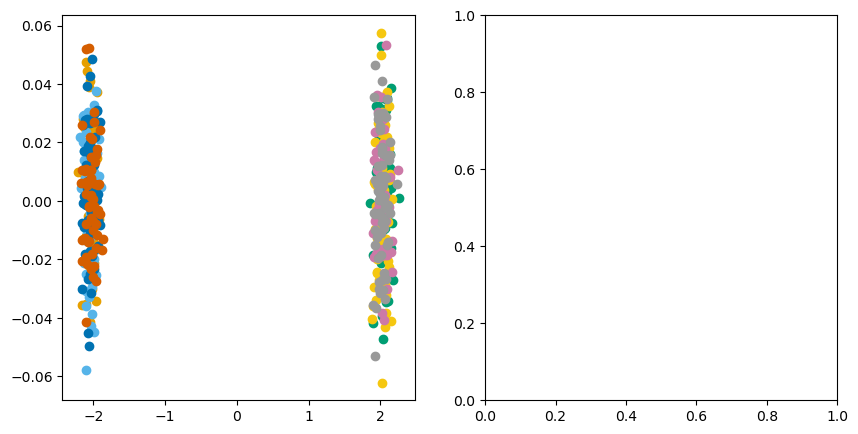

In [1538]:
init_state = cfqr.init_state
final_state = cfqr.sim.output.final_state

fig, ax = plt.subplots(1, 2, figsize = [10, 5])

for key, index, color in zip(particle_index.keys(), particle_index.values(), particle_color):
    xs = init_state[index][:, 0, 0]
    ys = init_state[index][:, 3, 0]
    # zs = init_state[index][:, 2, 0]
    graph = ax[0].plot(xs, ys, c = color, label = key, linestyle="", marker="o")

# ax = fig.add_subplot(1, 2, 2, projection='3d')

# for key, index, color in zip(particle_index.keys(), particle_index.values(), particle_color):
#     xs = final_state[index][:, 0, 0]
#     ys = final_state[index][:, 1, 0]
#     zs = final_state[index][:, 2, 0]
#     graph = ax.plot(xs, ys, zs, c = color, label = key, linestyle="", marker="o")

plt.show()

In [1539]:
print(f"W = {np.mean(cfqr.sim.work_dist_array):.3g}")


W = 36.5


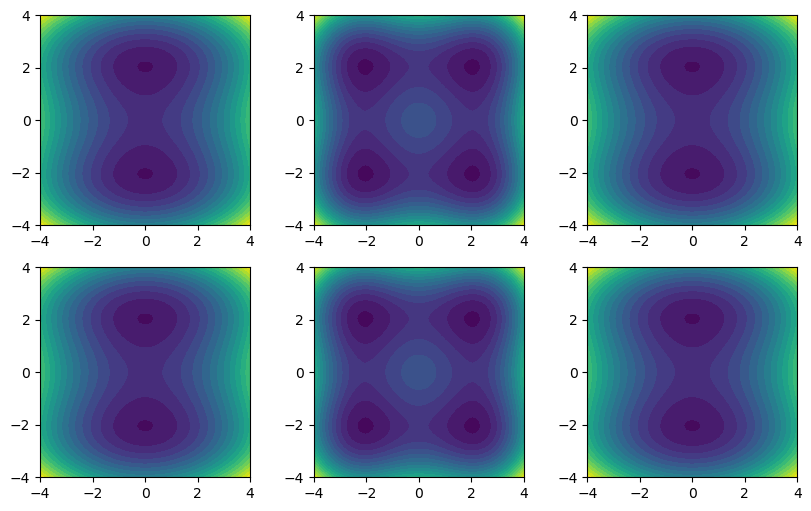

In [2539]:
parameter_dict = {
    "U0_1": U0_1, "U0_2": U0_2, "U0_3": U0_2, "gamma_1": gamma_1, "gamma_2": gamma_2, "gamma_3": gamma_3, 
    "beta_1": beta_1, "beta_2": beta_2, "beta_3": beta_3, "d_beta_1": d_beta_1, "d_beta_2": d_beta_2, "d_beta_3": d_beta_3, 
    "phi_1x": protocol_list[0]['phi_1x'], "phi_2x": protocol_list[0]['phi_2x'], "phi_3x": protocol_list[0]['phi_3x'], 
    "phi_1xdc": protocol_list[0]['phi_1xdc'], "phi_2xdc": protocol_list[0]['phi_2xdc'], "phi_3xdc": protocol_list[0]['phi_3xdc'], 
    "mu_12": protocol_list[0]['mu_12'], "mu_13": protocol_list[0]['mu_13'], "mu_23": protocol_list[0]['mu_23']
}


X, Y, U_12_top, U_12_bottom, U_23_left, U_23_right, U_13_front, U_13_back = get_XYU_6_plane(params = parameter_dict)
fig, ax = plt.subplots(2, 3, figsize = [10, 6])
contour_level = 20
contour_plot_12_top = ax[0][0].contourf(X, Y, U_12_top, contour_level)
contour_plot_12_bottom = ax[1][0].contourf(X, Y, U_12_bottom, contour_level)
contour_plot_23_right = ax[0][1].contourf(X, Y, U_23_right, contour_level)
contour_plot_23_left = ax[1][1].contourf(X, Y, U_23_left, contour_level)
contour_plot_13_front = ax[0][2].contourf(X, Y, U_13_front, contour_level)
contour_plot_13_back = ax[1][2].contourf(X, Y, U_13_back, contour_level)
[ax[0][i].set_aspect(1) for i in range(0, 3)]
[ax[1][i].set_aspect(1) for i in range(0, 3)]
plt.show()

In [ ]:
mu_12, mu_13, mu_23 = 0.1, 0.1, 0.1
xi_123 = 1 / (1 - mu_12**2 - mu_13**2 - mu_23**2 - 2 * mu_12 * mu_13 * mu_23)
w_array = np.linspace(-4, 4, 1000)
beta = 2.3
phi_3c = 2
phi_1xdc, phi_2xdc = 0, 0
phi_1x, phi_2x, phi_3x = 0, 0, 0

In [ ]:
mu_12, mu_13, mu_23 = 0.2, 0.2, 0.2
xi_123 = 1 / (1 - mu_12**2 - mu_13**2 - mu_23**2 - 2 * mu_12 * mu_13 * mu_23)
w_array = np.linspace(-4, 4, 1000)
beta = 2.3
phi_3c = 2
phi_1xdc, phi_2xdc = 0, 0
phi_1x, phi_2x, phi_3x = 0, 0, 2

dU_dw_up = dU_dw(beta = beta, mu_12 = mu_12, mu_13 = mu_13, mu_23 = mu_23, phi_1x = phi_1x, phi_2x = phi_2x, phi_3x = phi_3x, 
         phi_1dc = phi_1dc, phi_2dc = phi_2dc, phi_3c = phi_3c, w = w_array)

dU_dw_down = dU_dw(beta = beta, mu_12 = mu_12, mu_13 = mu_13, mu_23 = mu_23, phi_1x = phi_1x, phi_2x = phi_2x, phi_3x = phi_3x, 
         phi_1dc = phi_1dc, phi_2dc = phi_2dc, phi_3c = -phi_3c, w = w_array)

plt.plot(w_array, dU_dw_up, label = "z = c")
plt.plot(w_array, dU_dw_down, label = "z = -c")
plt.hlines(y = 0, xmin = -4, xmax = 4, linestyle = "--", color = "red")
plt.legend()

In [71]:
parameter_dict = {'U0_1': 112.12292445123691,
 'U0_2': 112.12292445123691,
 'U0_3': 112.12292445123691,
 'gamma_1': 20,
 'gamma_2': 20,
 'gamma_3': 20,
 'beta_1': 3.5,
 'beta_2': 3.5,
 'beta_3': 3.5,
 'd_beta_1': 0.0,
 'd_beta_2': 0.0,
 'd_beta_3': 0.0,
 'phi_1x': 0.4,
 'phi_2x': 0,
 'phi_3x': 0,
 'phi_1xdc': np.pi,
 'phi_2xdc': 0,
 'phi_3xdc': 0,
 'mu_12': 0.2,
 'mu_13': 0.2,
 'mu_23': 0.2}

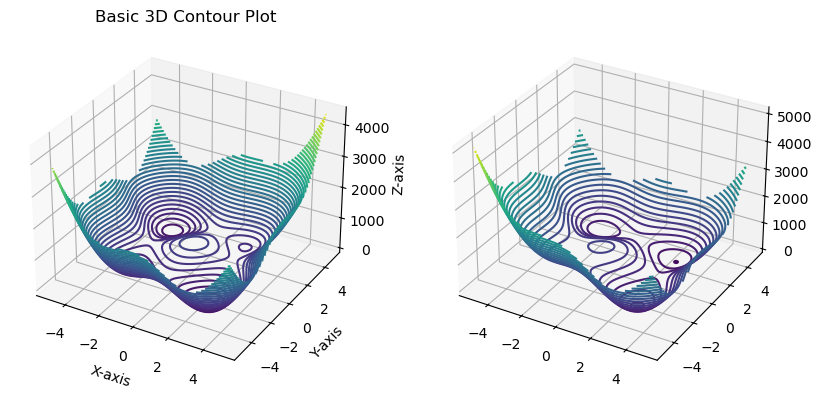

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Creating data
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = coupled_flux_qubit_3D_non_linear_approx_pot(X, Y, 2, parameter_dict['phi_1xdc'], parameter_dict['phi_2xdc'], parameter_dict['phi_3xdc'], \
                                                parameter_dict.values())


# Creating a 3D plot
fig = plt.figure(figsize = [10, 5])
ax = fig.add_subplot(1, 2, 1, projection='3d')
# Plotting the 3D contour
ax.contour3D(X, Y, Z, 50, cmap='viridis')

# Customizing the plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Basic 3D Contour Plot')

ax = fig.add_subplot(1, 2, 2, projection='3d')
Z = coupled_flux_qubit_3D_non_linear_approx_pot(X, Y, -2, parameter_dict['phi_1xdc'], parameter_dict['phi_2xdc'], parameter_dict['phi_3xdc'], \
                                                parameter_dict.values())
ax.contour3D(X, Y, Z, 50, cmap='viridis')


# Displaying the plot
plt.show()

In [73]:

for key, index, color in zip(particle_index.keys(), particle_index.values(), particle_color):
    xs = init_state[index][:, 0, 0]
    ys = init_state[index][:, 1, 0]
    zs = init_state[index][:, 2, 0]
    graph = ax.plot(xs, ys, zs, c = color, label = key, linestyle="", marker="o")

ax = fig.add_subplot(1, 2, 2, projection='3d')

for key, index, color in zip(particle_index.keys(), particle_index.values(), particle_color):
    xs = final_state[index][:, 0, 0]
    ys = final_state[index][:, 1, 0]
    zs = final_state[index][:, 2, 0]
    graph = ax.plot(xs, ys, zs, c = color, label = key, linestyle="", marker="o")

plt.show()